# Exploring Dandiset 001359: Human Patch-seq Electrophysiology Dataset

This notebook was generated with the assistance of AI. Please be cautious when interpreting the code or results and verify findings independently.

## Overview

This Dandiset contains human Patch-seq electrophysiology data from the Allen Institute for Brain Science. The dataset provides multimodal data for human neuron cell type classification, combining electrophysiological recordings with single-cell transcriptomics metadata. The data includes voltage and current clamp recordings from 33 human subjects with associated spike detection and detailed experimental annotations.

**Dataset Link:** https://dandiarchive.org/dandiset/001359/0.250401.1603

## Required Packages

The following packages are required to run this notebook:
- `dandi`
- `pynwb`
- `h5py`
- `remfile`
- `numpy`
- `matplotlib`
- `pandas`

In [1]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dandi.dandiapi import DandiAPIClient
import pynwb
import h5py
import remfile
from collections import Counter

## Exploring the Dandiset with DANDI API

In [2]:
# Connect to the dandiset and retrieve metadata
client = DandiAPIClient()
dandiset = client.get_dandiset("001359", "0.250401.1603")
metadata = dandiset.get_raw_metadata()
print(f"Dandiset name: {metadata['name']}")
print(f"Dandiset URL: {metadata['url']}")

Dandiset name: 20250331_AIBS_Patchseq_human
Dandiset URL: https://dandiarchive.org/dandiset/001359/0.250401.1603


## Exploring NWB Files in the Dandiset

In [3]:
# Get all .nwb assets and analyze file structure
assets = list(dandiset.get_assets_by_glob("*.nwb"))
paths = [asset.path for asset in assets]

# Analyze file organization
subjects = set()
for p in paths:
    parts = p.split('/')
    if len(parts) > 0 and parts[0].startswith('sub-'):
        subjects.add(parts[0])

print(f"Total NWB files: {len(paths)}")
print(f"Unique subjects: {len(subjects)}")
print("\nSample file paths:")
for path in paths[:5]:
    print(f"- {path}")

Total NWB files: 391
Unique subjects: 33

Sample file paths:
- sub-1203384279/sub-1203384279_ses-1207984257_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207304122_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207262032_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1207418023_icephys.nwb
- sub-1203384279/sub-1203384279_ses-1208065964_icephys.nwb


## Loading and Examining an Example NWB File

In [4]:
# Load a representative NWB file for exploration
nwb_path = paths[0]  # Use first file as example
asset = next(dandiset.get_assets_by_glob(nwb_path))
remote_file = remfile.File(asset.download_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

# Display key metadata
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Institution: {nwb.institution}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject age: {nwb.subject.age}")
print(f"Species: {nwb.subject.species}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.4, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Session description: PLACEHOLDER
Session start time: 2022-09-07 17:13:04.880000+00:00
Institution: Allen Institute for Brain Science
Subject ID: 1203384279
Subject sex: M
Subject age: P21170.0D
Species: Homo sapiens


/opt/conda/lib/python3.11/site-packages/pynwb/core.py:56: UserWarning: Use of icephys_filtering is deprecated and will be removed in PyNWB 4.0. Use the IntracellularElectrode.filtering field instead
  warn(error_msg)


## Analyzing Sweep Types and Data Structure

Total acquisition sweeps: 66
Sweep type counts: {'VoltageClampSeries': 7, 'CurrentClampSeries': 59}
Number of sweeps with detected spikes: 14
Total detected spikes: 431


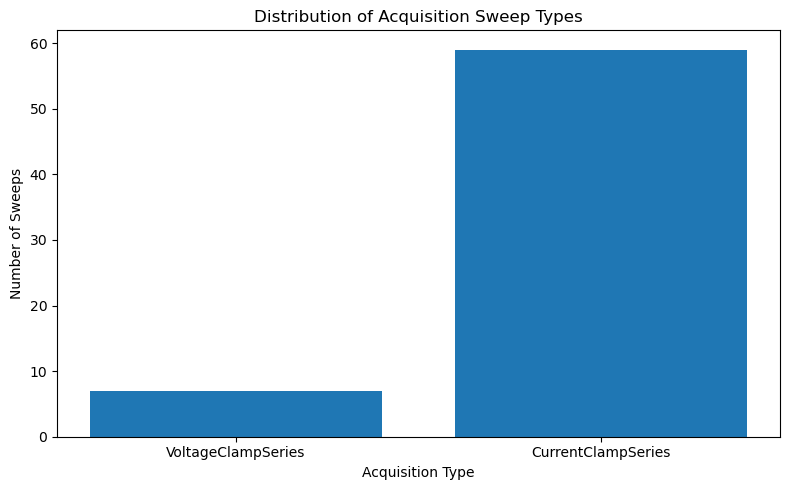

In [5]:
# Count different types of acquisition sweeps
acq_types = [type(obj).__name__ for obj in nwb.acquisition.values()]
type_counts = Counter(acq_types)

# Count sweeps with detected spikes
if 'spikes' in nwb.processing:
    spikes = nwb.processing['spikes']
    spike_sweep_counts = [(name, len(ifc.data[:])) for name, ifc in spikes.data_interfaces.items()]
    num_sweeps_with_spikes = sum(n > 0 for _, n in spike_sweep_counts)
    total_detected_spikes = sum(n for _, n in spike_sweep_counts)
else:
    num_sweeps_with_spikes = 0
    total_detected_spikes = 0

print(f"Total acquisition sweeps: {len(nwb.acquisition)}")
print("Sweep type counts:", dict(type_counts))
print(f"Number of sweeps with detected spikes: {num_sweeps_with_spikes}")
print(f"Total detected spikes: {total_detected_spikes}")

# Visualize sweep type distribution
plt.figure(figsize=(8, 5))
plt.bar(type_counts.keys(), type_counts.values())
plt.xlabel('Acquisition Type')
plt.ylabel('Number of Sweeps')
plt.title('Distribution of Acquisition Sweep Types')
plt.tight_layout()
plt.show()

## Visualizing Electrophysiological Traces

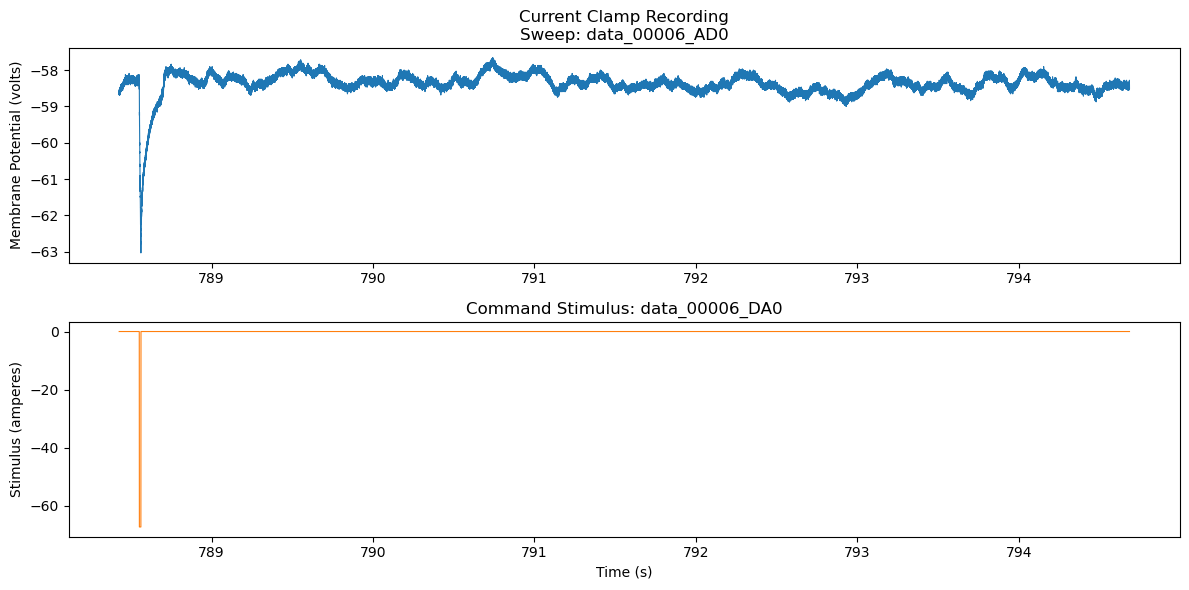

In [6]:
# Select and plot a current clamp sweep with its stimulus
cc_sweeps = [(name, obj) for name, obj in nwb.acquisition.items() if type(obj).__name__ == 'CurrentClampSeries']
example_sweep_name, example_sweep = cc_sweeps[0]

# Get corresponding stimulus
stim_name = example_sweep_name.replace('_AD0', '_DA0')
example_stimulus = nwb.stimulus.get(stim_name)

# Load full sweep data
trace = example_sweep.data[:]
stim = example_stimulus.data[:] if example_stimulus is not None else None
rate = example_sweep.rate
start_time = example_sweep.starting_time
t = np.arange(len(trace)) / rate + start_time

# Plot trace and stimulus
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, trace, color='tab:blue', linewidth=0.8)
plt.ylabel(f"Membrane Potential ({example_sweep.unit})")
plt.title(f"Current Clamp Recording\nSweep: {example_sweep_name}")

plt.subplot(2, 1, 2)
if stim is not None:
    plt.plot(t, stim, color='tab:orange', linewidth=0.8)
    plt.ylabel(f"Stimulus ({example_stimulus.unit})")
    plt.title(f"Command Stimulus: {stim_name}")
plt.xlabel('Time (s)')
plt.tight_layout()
plt.show()

## Visualizing Detected Spikes

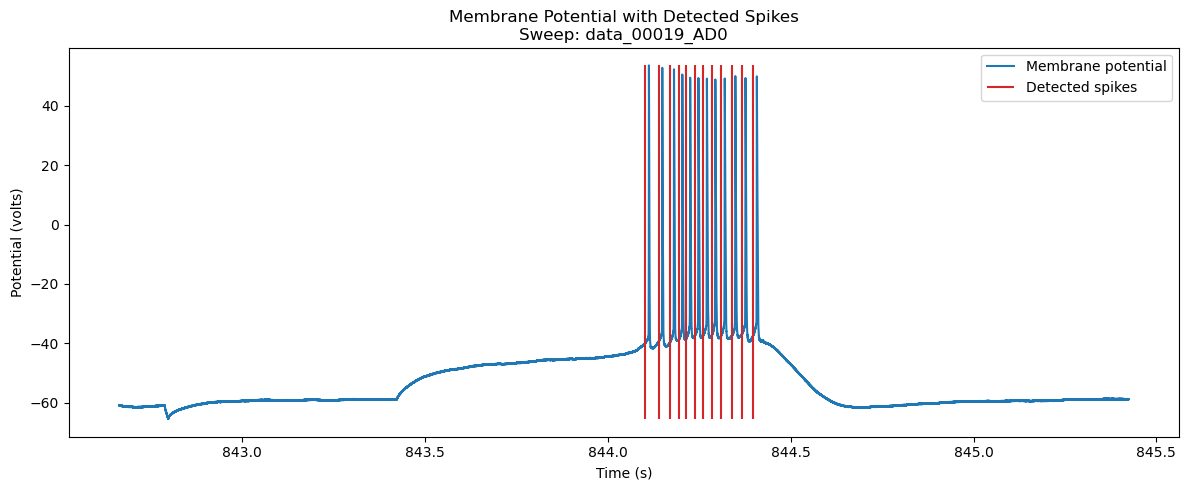

Number of detected spikes: 12
Spike times (first 5): [844.10260003 844.13902003 844.17100003 844.19372003 844.21516003]


In [7]:
# Find a sweep with detected spikes and visualize them
spike_mod = nwb.processing['spikes']
sweep_with_spikes = None
for name, ts in spike_mod.data_interfaces.items():
    if hasattr(ts, 'data') and len(ts.data[:]) > 0:
        sweep_with_spikes = (name, ts)
        break

if sweep_with_spikes:
    sweep_name, spike_ts = sweep_with_spikes
    # Find matching acquisition trace
    swnum = int(sweep_name.replace('Sweep_', ''))
    match = [(nm, obj) for nm, obj in nwb.acquisition.items() 
             if hasattr(obj, 'sweep_number') and obj.sweep_number == swnum]
    
    if match:
        acq_name, acq_obj = match[0]
        trace = acq_obj.data[:]
        rate = acq_obj.rate
        start_time = acq_obj.starting_time
        t = np.arange(len(trace)) / rate + start_time
        
        # Correct spike times (add sweep start time and 0.25s offset)
        spike_times = spike_ts.data[:] + start_time + 0.25
        
        # Handle NaN values for plotting spike markers
        not_nan = ~np.isnan(trace)
        trace_min = np.min(trace[not_nan]) if np.any(not_nan) else -70
        trace_max = np.max(trace[not_nan]) if np.any(not_nan) else 40
        
        plt.figure(figsize=(12, 5))
        plt.plot(t, trace, label='Membrane potential', color='tab:blue')
        plt.vlines(spike_times, trace_min, trace_max, color='tab:red', 
                   label='Detected spikes', linewidth=1.5)
        plt.xlabel('Time (s)')
        plt.ylabel(f'Potential ({acq_obj.unit})')
        plt.title(f'Membrane Potential with Detected Spikes\nSweep: {acq_name}')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Number of detected spikes: {len(spike_times)}")
        print(f"Spike times (first 5): {spike_times[:5]}")

## Analyzing Experimental Epochs and Annotations

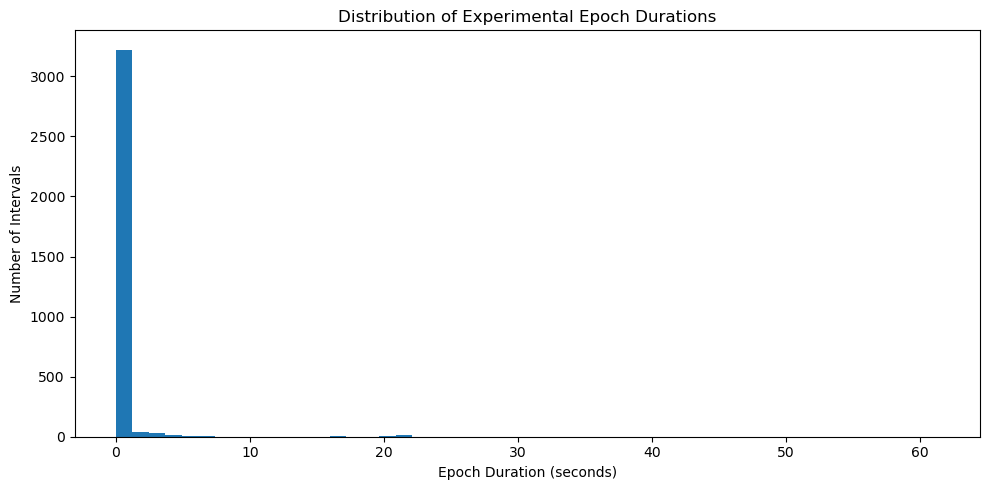

Total epochs: 3352

Epoch duration statistics:
count    3352.000000
mean        0.406164
std         2.393813
min         0.000453
25%         0.021827
50%         0.039837
75%         0.124521
max        61.384995
dtype: float64

Most common experimental tags:
Type=Epoch                 2825
Epoch=1                    2666
EpochType=Sin Wave         2614
Amplitude=15               2075
Half Cycle=0                868
Half Cycle=1                865
Amplitude=14                515
EpochType=Square pulse      207
Type=Inserted Testpulse     196
Amplitude=0                 139
Name: count, dtype: int64


In [8]:
# Examine experimental intervals (epochs) and their annotations
if hasattr(nwb, 'epochs') and nwb.epochs is not None:
    epochs_df = nwb.epochs.to_dataframe().copy()
    durations = epochs_df['stop_time'] - epochs_df['start_time']
    
    # Plot epoch duration distribution
    plt.figure(figsize=(10, 5))
    plt.hist(durations, bins=50)
    plt.xlabel('Epoch Duration (seconds)')
    plt.ylabel('Number of Intervals')
    plt.title('Distribution of Experimental Epoch Durations')
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"Total epochs: {len(epochs_df)}")
    print("\nEpoch duration statistics:")
    print(durations.describe())
    
    # Analyze most common experimental tags
    all_tags = [tag for tags_list in epochs_df['tags'] for tag in tags_list]
    tag_counts = pd.Series(all_tags).value_counts().head(10)
    print("\nMost common experimental tags:")
    print(tag_counts)

## Summary

This notebook demonstrated how to:

1. **Access the Dandiset**: Use the DANDI API to explore file organization across 33 human subjects and 391 NWB files
2. **Load NWB data**: Stream remote files and extract electrophysiological recordings, stimuli, and metadata
3. **Visualize recordings**: Plot current clamp traces with corresponding stimulus waveforms
4. **Analyze spike detection**: Overlay detected spike times on membrane potential traces with proper time alignment
5. **Explore experimental structure**: Examine thousands of annotated experimental intervals and protocol phases

This Patch-seq dataset provides rich multimodal data suitable for neuron classification, protocol analysis, and cross-modal studies combining electrophysiology with transcriptomics. The extensive epoch annotations enable precise, protocol-aware analyses for advanced reuse of these human neuronal recordings.